# Overall code framework

## Utility cells

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Learning algorithms used

In [4]:
import numpy as np
import pandas as pd
import seaborn

from functions import *

from sklearn.datasets import make_blobs, make_hastie_10_2, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# n_samples = 1000

knn = KNeighborsClassifier(n_neighbors=1)
tree = DecisionTreeClassifier(max_depth=1)
lda = LinearDiscriminantAnalysis()
nb = GaussianNB()

models = {
    '1-NN': knn,
    'Stump': tree,
    'LDA': lda,
    'NB': nb
}

random_state = None

## Meta dataset generator

In [103]:
folder = 'data/datasets_artificial/00'
ids = get_ids(folder)
metaX = []
metay = []
for id in ids:
    print(f"ID: {id}")
    X, y = load_dataset(folder, id)
    metafeatures = extract_metafeatures(X, y)
    metaX.append(metafeatures)
    metalabel = get_metalabel(X, y, models)
    metay.append(metalabel)

metaX = np.stack(metaX)
metay = np.stack(metay)

save_folder = 'data/datasets_meta'
np.save(f'{save_folder}/artificial00data.npy', metaX)
np.save(f'{save_folder}/artificial00label.npy', metay)
np.save('data/meta_ids/artificial00ids.npy', np.asarray(ids))


ID: 0-0-0
ID: 0-0-10
ID: 0-0-11
ID: 0-0-12
ID: 0-0-13
ID: 0-0-14
ID: 0-0-15
ID: 0-0-16
ID: 0-0-17
ID: 0-0-18
ID: 0-0-19
ID: 0-0-1
ID: 0-0-20
ID: 0-0-21
ID: 0-0-22
ID: 0-0-23
ID: 0-0-24
ID: 0-0-25
ID: 0-0-26
ID: 0-0-27
ID: 0-0-28
ID: 0-0-29
ID: 0-0-2
ID: 0-0-30
ID: 0-0-31
ID: 0-0-32
ID: 0-0-33
ID: 0-0-34
ID: 0-0-35
ID: 0-0-36
ID: 0-0-37
ID: 0-0-38
ID: 0-0-39
ID: 0-0-3
ID: 0-0-40
ID: 0-0-41
ID: 0-0-42
ID: 0-0-43
ID: 0-0-44
ID: 0-0-45
ID: 0-0-46
ID: 0-0-47
ID: 0-0-48
ID: 0-0-49
ID: 0-0-4
ID: 0-0-50
ID: 0-0-51
ID: 0-0-52
ID: 0-0-53
ID: 0-0-54
ID: 0-0-55
ID: 0-0-56
ID: 0-0-57
ID: 0-0-58
ID: 0-0-59
ID: 0-0-5
ID: 0-0-60
ID: 0-0-61
ID: 0-0-62
ID: 0-0-63
ID: 0-0-64
ID: 0-0-65
ID: 0-0-66
ID: 0-0-67
ID: 0-0-68
ID: 0-0-69
ID: 0-0-6
ID: 0-0-70
ID: 0-0-71
ID: 0-0-72
ID: 0-0-73
ID: 0-0-74
ID: 0-0-75
ID: 0-0-76
ID: 0-0-77
ID: 0-0-78
ID: 0-0-79
ID: 0-0-7
ID: 0-0-80
ID: 0-0-81
ID: 0-0-82
ID: 0-0-83
ID: 0-0-84
ID: 0-0-85
ID: 0-0-86
ID: 0-0-87
ID: 0-0-88
ID: 0-0-89
ID: 0-0-8
ID: 0-0-90
ID: 0-0-91
ID: 0-0-

Expertise space distribution

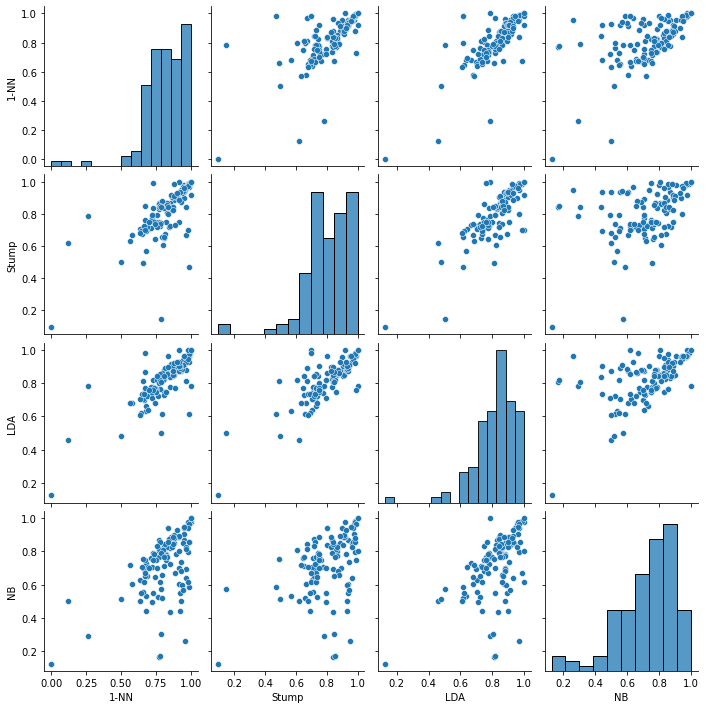

In [25]:
import seaborn

ids = np.load('data/meta_ids/openmlids.npy')

df_openml = compute_expertise_space(models, 'data/datasets_openml', ids)
seaborn.pairplot(df_openml).savefig(f'openml-pairwise.png')

In [26]:
expertise_openml = df_openml.to_numpy()
uniformity_test(expertise_openml)

2.5833824364766485e-272

## Meta dataset analysis

In [104]:
folder = 'data/datasets_meta'
X, y = load_dataset(folder, 'openml')

df_algofrequency = pd.DataFrame(data=y.sum(axis=0), index=models.keys(), columns=("Frequency",))
display(df_algofrequency)
print(f"Choose mode: {y.sum(axis=0).max() / y.shape[0]}")
print(f"Choose random: {y.sum() / y.size}")

,Frequency
1-NN,34
Stump,43
LDA,46
NB,12


Choose mode: 0.3865546218487395
Choose random: 0.28361344537815125


## Meta learner

In [124]:
def aggregate(confusion):
    accuracy = np.trace(confusion) / confusion.sum()
    recall = confusion.diagonal() / confusion.sum(axis=0)
    precision = confusion.diagonal() / confusion.sum(axis=1)
    return accuracy, recall, precision

def compute_meta_accuracy(y_true, y_pred):
    total_selected = 0
    num_correct = 0
    for model in y_true:
        total_selected += y_pred[model].sum()
        num_correct += y[model][np.where(y_pred[model] == 1)].sum()
    return num_correct / total_selected

In [134]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

folder = 'data/datasets_meta'
folds = StratifiedKFold(n_splits=10, shuffle=True)
X, y = load_dataset(folder, 'openml')
y = {list(models.keys())[i]: y[:, i] for i in range(len(models))}

# uniformity_scores = []
y_pred = {}
confusion_mat = {}
metrics = {
    'Accuracy': [],
    'Precision0': [],
    'Precision1': [],
    'Recall0': [],
    'Recall1': []
}

for model in models:
    y_pred[model] = np.zeros(y[model].shape)
    for train, test in folds.split(X, y[model]):
        allnn = KNeighborsClassifier(n_neighbors=train.size, weights='distance')
        allnn.fit(X[train], y[model][train])
        predictions = allnn.predict(X[test])
        
        y_pred[model][test] = predictions

        # uniformity_score = uniformity_test(expertise_openml[train])
        # uniformity_scores.append(uniformity_score)

        # print(f"Uniformity: {uniformity_score}")

    confusion_mat[model] = confusion_matrix(y[model], y_pred[model])
    acc, precision, recall = aggregate(confusion_mat[model])
    metrics['Accuracy'].append(acc)
    metrics['Precision0'].append(precision[0])
    metrics['Precision1'].append(precision[1])
    metrics['Recall0'].append(recall[0])
    metrics['Recall1'].append(recall[1])

print("Purely OpenML")
display(pd.DataFrame(data=metrics, index=models.keys()))
display(confusion_mat)
print(f"Accuracy: {compute_meta_accuracy(y, y_pred)}")

Purely OpenML


,Accuracy,Precision0,Precision1,Recall0,Recall1
1-NN,0.731092,0.743119,0.600000,0.952941,0.176471
Stump,0.680672,0.690000,0.631579,0.907895,0.279070
LDA,0.546218,0.592233,0.250000,0.835616,0.086957
NB,0.890756,0.898305,0.000000,0.990654,0.000000


{'1-NN': array([[81,  4],
        [28,  6]], dtype=int64),
 'Stump': array([[69,  7],
        [31, 12]], dtype=int64),
 'LDA': array([[61, 12],
        [42,  4]], dtype=int64),
 'NB': array([[106,   1],
        [ 12,   0]], dtype=int64)}

Accuracy: 0.4782608695652174


In [149]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

folder = 'data/datasets_meta'
folds = StratifiedKFold(n_splits=10, shuffle=True)
X, y = load_dataset(folder, 'openml')
y = {list(models.keys())[i]: y[:, i] for i in range(len(models))}

y_pred = {}
openml_acc = []
for i in range(100):
    for model in models:
        y_pred[model] = np.zeros(y[model].shape)
        for train, test in folds.split(X, y[model]):
            allnn = KNeighborsClassifier(n_neighbors=train.size, weights='distance')
            allnn.fit(X[train], y[model][train])
            predictions = allnn.predict(X[test])
            y_pred[model][test] = predictions
    openml_acc.append(compute_meta_accuracy(y, y_pred))

print("Purely OpenML")
print(f"Accuracy: {openml_acc}")

Purely OpenML
Accuracy: [0.42857142857142855, 0.4772727272727273, 0.4772727272727273, 0.475, 0.5116279069767442, 0.4888888888888889, 0.46808510638297873, 0.4888888888888889, 0.5652173913043478, 0.5217391304347826, 0.4418604651162791, 0.4782608695652174, 0.4772727272727273, 0.5531914893617021, 0.5263157894736842, 0.5238095238095238, 0.4375, 0.4666666666666667, 0.5217391304347826, 0.45652173913043476, 0.4772727272727273, 0.4883720930232558, 0.5365853658536586, 0.4807692307692308, 0.4583333333333333, 0.47619047619047616, 0.5, 0.5, 0.5116279069767442, 0.5238095238095238, 0.5, 0.5116279069767442, 0.5, 0.5121951219512195, 0.46, 0.48, 0.5, 0.5111111111111111, 0.5348837209302325, 0.5238095238095238, 0.5319148936170213, 0.4444444444444444, 0.4888888888888889, 0.5, 0.4888888888888889, 0.5, 0.5217391304347826, 0.48936170212765956, 0.4418604651162791, 0.5319148936170213, 0.4888888888888889, 0.46938775510204084, 0.46808510638297873, 0.5116279069767442, 0.44680851063829785, 0.4878048780487805, 0.478

In [136]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

folder = 'data/datasets_meta'
folds = StratifiedKFold(n_splits=10, shuffle=True)
X, y = load_dataset(folder, 'openml')
y = {list(models.keys())[i]: y[:, i] for i in range(len(models))}
X21, y21 = load_dataset(folder, 'artificial21')
y21 = {list(models.keys())[i]: y21[:, i] for i in range(len(models))}

# uniformity_scores = []
y_pred = {}
confusion_mat = {}
metrics = {
    'Accuracy': [],
    'Precision0': [],
    'Precision1': [],
    'Recall0': [],
    'Recall1': []
}

for model in models:
    y_pred[model] = np.zeros(y[model].shape)
    for train, test in folds.split(X, y[model]):
        allnn = KNeighborsClassifier(n_neighbors=train.size, weights='distance')
        allnn.fit(np.concatenate([X[train], X21]), np.concatenate([y[model][train], y21[model]]))
        predictions = allnn.predict(X[test])
        
        y_pred[model][test] = predictions

        # uniformity_score = uniformity_test(expertise_openml[train])
        # uniformity_scores.append(uniformity_score)

        # print(f"Uniformity: {uniformity_score}")

    confusion_mat[model] = confusion_matrix(y[model], y_pred[model])
    acc, precision, recall = aggregate(confusion_mat[model])
    metrics['Accuracy'].append(acc)
    metrics['Precision0'].append(precision[0])
    metrics['Precision1'].append(precision[1])
    metrics['Recall0'].append(recall[0])
    metrics['Recall1'].append(recall[1])

print("Blended in artificial datasets")
display(pd.DataFrame(data=metrics, index=models.keys()))
display(confusion_mat)
print(f"Accuracy: {compute_meta_accuracy(y, y_pred)}")

Blended in artificial datasets


,Accuracy,Precision0,Precision1,Recall0,Recall1
1-NN,0.705882,0.727273,0.444444,0.941176,0.117647
Stump,0.638655,0.673684,0.500000,0.842105,0.279070
LDA,0.588235,0.615385,0.400000,0.876712,0.130435
NB,0.899160,0.905983,0.500000,0.990654,0.083333


{'1-NN': array([[80,  5],
        [30,  4]], dtype=int64),
 'Stump': array([[64, 12],
        [31, 12]], dtype=int64),
 'LDA': array([[64,  9],
        [40,  6]], dtype=int64),
 'NB': array([[106,   1],
        [ 11,   1]], dtype=int64)}

Accuracy: 0.46


In [147]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

folder = 'data/datasets_meta'
folds = StratifiedKFold(n_splits=10, shuffle=True)
X, y = load_dataset(folder, 'openml')
y = {list(models.keys())[i]: y[:, i] for i in range(len(models))}
X21, y21 = load_dataset(folder, 'artificial21')
y21 = {list(models.keys())[i]: y21[:, i] for i in range(len(models))}

y_pred = {}
blended_acc = []
for i in range(100):
    for model in models:
        y_pred[model] = np.zeros(y[model].shape)
        for train, test in folds.split(X, y[model]):
            allnn = KNeighborsClassifier(n_neighbors=train.size, weights='distance')
            allnn.fit(np.concatenate([X[train], X21]), np.concatenate([y[model][train], y21[model]]))
            predictions = allnn.predict(X[test])
            y_pred[model][test] = predictions
    blended_acc.append(compute_meta_accuracy(y, y_pred))


print("Blended in artificial datasets")
print(f"Accuracy: {blended_acc}")

Blended in artificial datasets
Accuracy: [0.4791666666666667, 0.4782608695652174, 0.5, 0.4888888888888889, 0.4791666666666667, 0.42857142857142855, 0.4782608695652174, 0.46296296296296297, 0.4166666666666667, 0.5, 0.45454545454545453, 0.4772727272727273, 0.5111111111111111, 0.5319148936170213, 0.4423076923076923, 0.4782608695652174, 0.4897959183673469, 0.46, 0.4791666666666667, 0.48936170212765956, 0.47058823529411764, 0.5, 0.42, 0.5, 0.49056603773584906, 0.4583333333333333, 0.46938775510204084, 0.45454545454545453, 0.48, 0.5, 0.4791666666666667, 0.48, 0.46938775510204084, 0.4782608695652174, 0.44680851063829785, 0.4897959183673469, 0.5, 0.5192307692307693, 0.5098039215686274, 0.46938775510204084, 0.46808510638297873, 0.45652173913043476, 0.48936170212765956, 0.425531914893617, 0.5, 0.5102040816326531, 0.4791666666666667, 0.48936170212765956, 0.5227272727272727, 0.5, 0.5, 0.47058823529411764, 0.43137254901960786, 0.5238095238095238, 0.4897959183673469, 0.46296296296296297, 0.5238095238

In [150]:
from scipy.stats import ttest_ind
print(np.mean(openml_acc))
print(np.mean(blended_acc))
ttest_ind(openml_acc, blended_acc)

0.49116795386912687
0.4790884715524843


Ttest_indResult(statistic=2.8062780561676433, pvalue=0.005512292977548272)

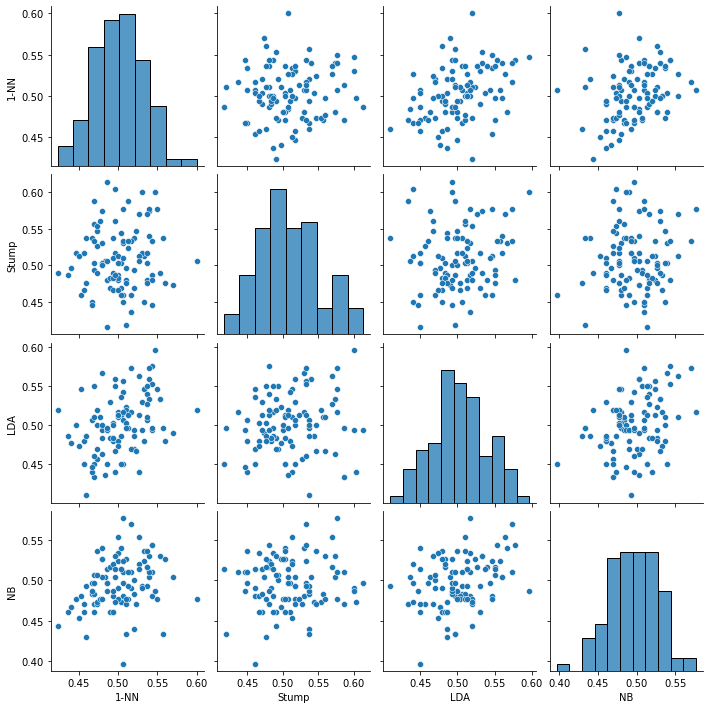

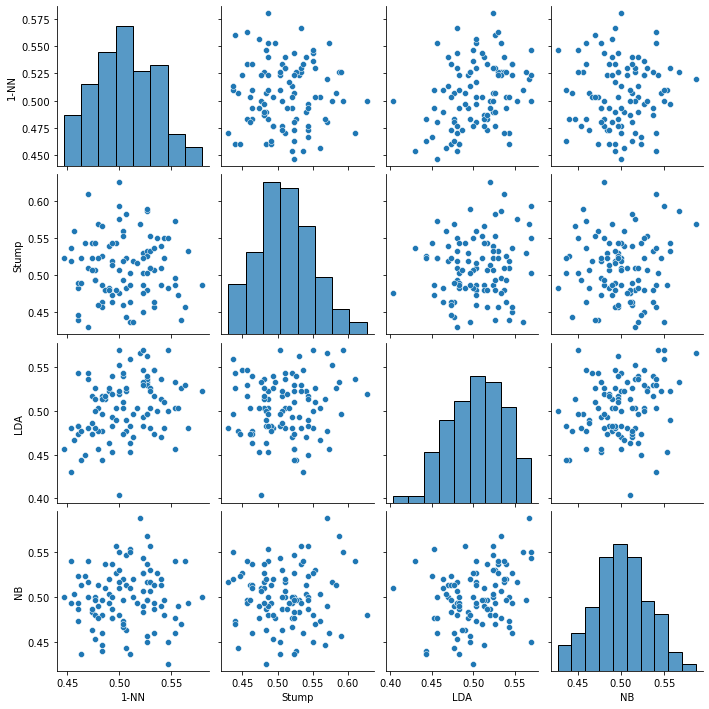

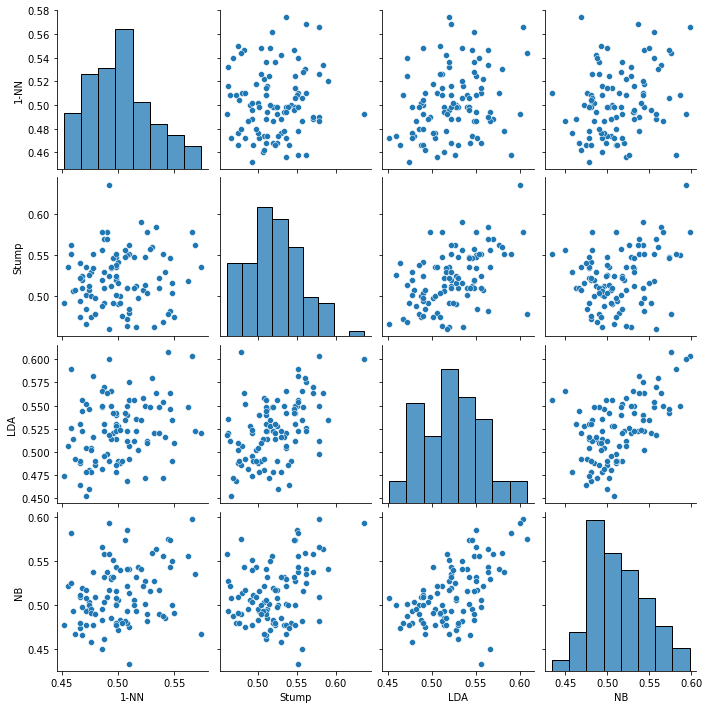

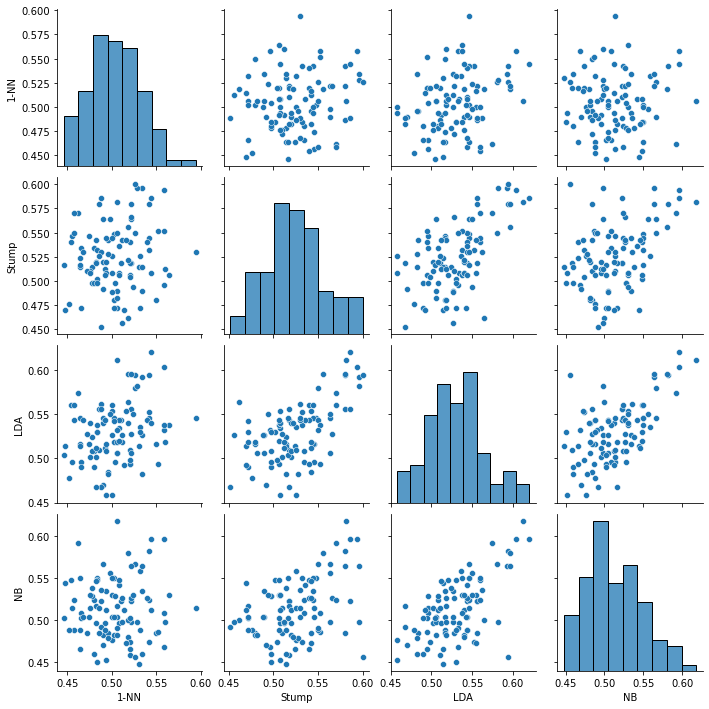

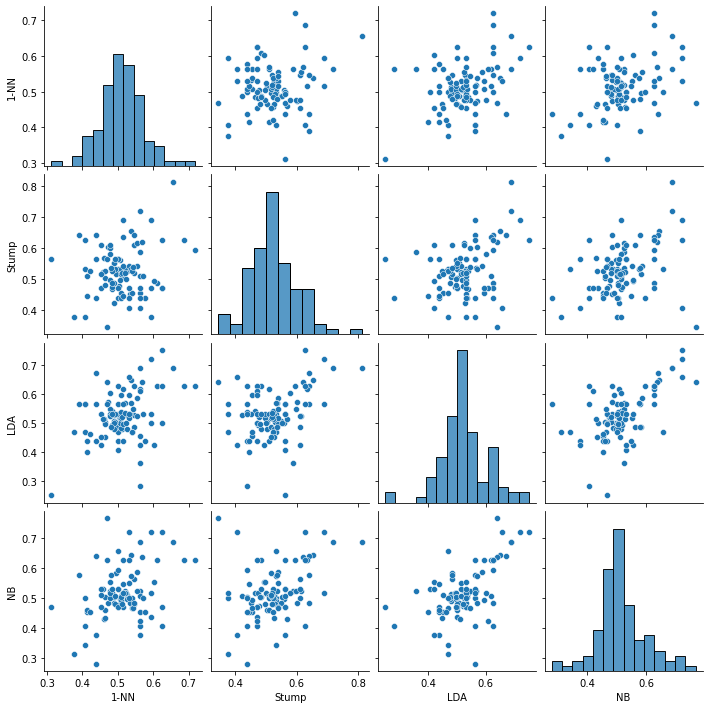

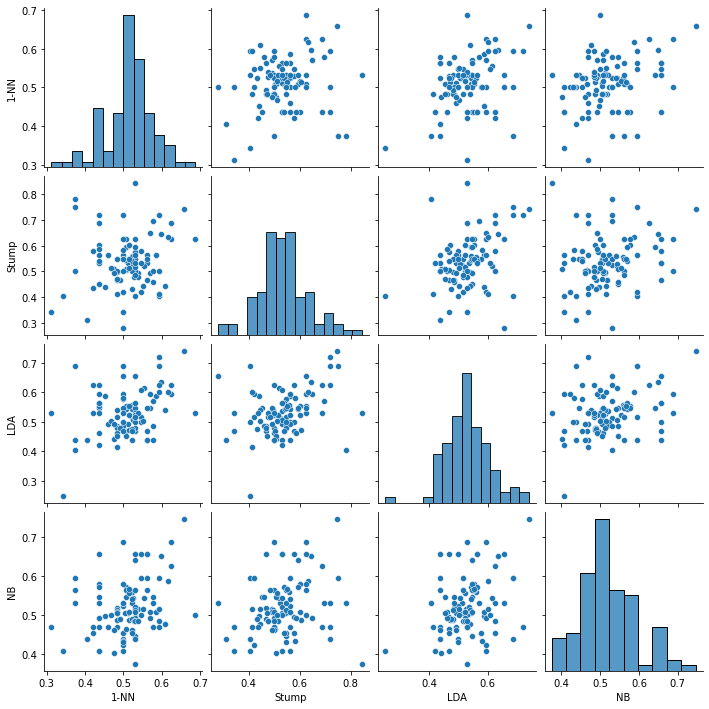

In [101]:
import seaborn

np_choices = [0, 1, 2]
c_choices = [0, 1]

df_artificial = np.zeros((3, 2)).tolist()
for p in np_choices:
    for c in c_choices:
        folder = f'data/datasets_artificial/{p}{c}'
        df_artificial[p][c] = compute_expertise_space(models, folder)
        seaborn.pairplot(df_artificial[p][c]).savefig(f'{p}{c}-pairwise.png')


In [151]:
uniformity_scores = np.zeros((3, 2))
for p in np_choices:
    for c in c_choices:
        uniformity_scores[p, c] = uniformity_test(df_artificial[p][c].to_numpy())
uniformity_scores

array([[1.78894356e-02, 7.99848303e-02],
       [1.12331934e-11, 2.03271868e-18],
       [1.87068569e-06, 6.19852067e-17]])

# Actions

Inverting on separate datasets

In [59]:
for dataset_id in range(100):
    plt.figure()
    for name, model in models.items():
        acc = []
        X, y = load_dataset(dataset_id)

        # X, y = make_classification(n_samples=n_samples, random_state=random_state)
        
        # X, y = make_hastie_10_2(n_samples=n_samples, random_state=random_state)
        # y = np.where(y == -1, 0, y)
        
        # X, y = make_blobs(n_samples=n_samples, n_features=2, centers=2, cluster_std=1, random_state=random_state)

        # X, y = make_blobs(n_samples=n_samples, n_features=10, centers=1, cluster_std=1, random_state=random_state)
        # y = np.concatenate((np.zeros(n_samples//2), np.ones(n_samples//2)))
        
        for i in range(30):
            accuracy, errors = evaluate(X, y, model)
            acc.append(accuracy)
            # a means >= 15 invert random, b means < 15 invert random
            if i >= 15:
                X, y = invert_random(X, y)
            else:
                X, y = invert_errors(X, y, model)

        plt.plot(acc, label=name)


    plt.xlabel('Action iteration')
    plt.ylabel('Accuracy')
    plt.legend()
    # plt.show()
    plt.savefig(f'a{dataset_id}.png')

Inverting off a single dataset

In [57]:
# X, y = make_classification(n_samples=n_samples, random_state=random_state, class_sep=1.0)

X, y = make_hastie_10_2(n_samples=n_samples, random_state=random_state)
y = np.where(y == -1, 0, y)

# X, y = make_blobs(n_samples=n_samples, n_features=2, centers=2, cluster_std=1, random_state=random_state)

# X, y = make_blobs(n_samples=n_samples, n_features=10, centers=1, cluster_std=1, random_state=random_state)
# y = np.concatenate((np.zeros(n_samples//2), np.ones(n_samples//2)))

acc = {name:[] for name in models}
for i in range(30):
    print(np.unique(y, return_counts=True)[1])
    for name, model in models.items():
        accuracy, errors = evaluate(X, y, model)
        acc[name].append(accuracy)
    if i >= 15:
        X, y = invert_random(X, y)
    else:
        # list(models.keys())[i % 4]
        X, y = invert_errors(X, y, models[list(models.keys())[i % 4]])

for name, values in acc.items():
    plt.plot(values, label=name)

plt.xlabel('Action iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()